```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Modeling COVID 19 <single: Modeling COVID 19>`

```{contents} Contents
:depth: 2
```

## Overview

This is a Python version of the code for analyzing the COVID-19 pandemic
provided by [Andrew Atkeson](https://sites.google.com/site/andyatkeson/).

See, in particular

* [NBER Working Paper No. 26867](https://www.nber.org/papers/w26867)
* [COVID-19 Working papers and code](https://sites.google.com/site/andyatkeson/home?authuser=0)

The purpose of his notes is to introduce economists to quantitative modeling
of infectious disease dynamics.

Dynamics are modeled using a standard SIR (Susceptible-Infected-Removed) model
of disease spread.

The model dynamics are represented by a system of ordinary differential
equations.

The main objective is to study the impact of suppression through social
distancing on the spread of the infection.

The focus is on US outcomes but the parameters can be adjusted to study
other countries.

We will use the following standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp

We will also use SciPy's numerical routine odeint for solving differential
equations.

In [2]:
from scipy.integrate import odeint

This routine calls into compiled code from the FORTRAN library odepack.

## The SIR Model

In the version of the SIR model we will analyze there are four states.

All individuals in the population are assumed to be in one of these four states.

The states are: susceptible (S), exposed (E), infected (I) and removed (R).

Comments:

* Those in state R have been infected and either recovered or died.
* Those who have recovered are assumed to have acquired immunity.
* Those in the exposed group are not yet infectious.

### Time Path

The flow across states follows the path $S \to E \to I \to R$.

All individuals in the population are eventually infected when
the transmission rate is positive and $i(0) > 0$.

The interest is primarily in

* the number of infections at a given time (which determines whether or not the health care system is overwhelmed) and
* how long the caseload can be deferred (hopefully until a vaccine arrives)

Using lower case letters for the fraction of the population in each state, the
dynamics are

```{math}
:label: sir_system

\begin{aligned}
     \dot s(t)  & = - \beta(t) \, s(t) \,  i(t)
     \\
     \dot e(t)  & = \beta(t) \,  s(t) \,  i(t)  - σ e(t)
     \\
     \dot i(t)  & = σ e(t)  - γ i(t)
\end{aligned}
```

In these equations,

* $\beta(t)$ is called the *transmission rate* (the rate at which individuals bump into others and expose them to the virus).
* $\sigma$ is called the *infection rate* (the rate at which those who are exposed become infected)
* $\gamma$ is called the *recovery rate* (the rate at which infected people recover or die).
* the dot symbol $\dot y$ represents the time derivative $dy/dt$.

We do not need to model the fraction $r$ of the population in state $R$ separately because the states form a partition.

In particular, the "removed" fraction of the population is $r = 1 - s - e - i$.

We will also track $c = i + r$, which is the cumulative caseload
(i.e., all those who have or have had the infection).

The system {eq}`sir_system` can be written in vector form as

```{math}
:label: dfcv

\dot x = F(x, t),  \qquad x := (s, e, i)
```

for suitable definition of $F$ (see the code below).

### Parameters

Both $\sigma$ and $\gamma$ are thought of as fixed, biologically determined parameters.

As in Atkeson's note, we set

* $\sigma = 1/5.2$ to reflect an average incubation period of 5.2 days.
* $\gamma = 1/18$ to match an average illness duration of 18 days.

The transmission rate is modeled as

* $\beta(t) := R(t) \gamma$ where $R(t)$ is the *effective reproduction number* at time $t$.

(The notation is slightly confusing, since $R(t)$ is different to
$R$, the symbol that represents the removed state.)

## Implementation

First we set the population size to match the US.

In [3]:
pop_size = 3.3e8

Next we fix parameters as described above.

In [4]:
γ = 1 / 18
σ = 1 / 5.2

Now we construct a function that represents $F$ in {eq}`dfcv`

In [5]:
def F(x, t, R0=1.6):
    """
    Time derivative of the state vector.

        * x is the state vector (array_like)
        * t is time (scalar)
        * R0 is the effective transmission rate, defaulting to a constant

    """
    s, e, i = x

    # New exposure of susceptibles
    β = R0(t) * γ if callable(R0) else R0 * γ
    ne = β * s * i

    # Time derivatives
    ds = - ne
    de = ne - σ * e
    di = σ * e - γ * i

    return ds, de, di

Note that `R0` can be either constant or a given function of time.

The initial conditions are set to

In [6]:
# initial conditions of s, e, i
i_0 = 1e-7
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0

In vector form the initial condition is

In [7]:
x_0 = s_0, e_0, i_0

We solve for the time path numerically using odeint, at a sequence of dates
`t_vec`.

In [8]:
def solve_path(R0, t_vec, x_init=x_0):
    """
    Solve for i(t) and c(t) via numerical integration,
    given the time path for R0.

    """
    G = lambda x, t: F(x, t, R0)
    s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()

    c_path = 1 - s_path - e_path       # cumulative cases
    return i_path, c_path

## Experiments

Let's run some experiments using this code.

The time period we investigate will be 550 days, or around 18 months:

In [9]:
t_length = 550
grid_size = 1000
t_vec = np.linspace(0, t_length, grid_size)

### Experiment 1: Constant R0 Case

Let's start with the case where `R0` is constant.

We calculate the time path of infected people under different assumptions for `R0`:

In [10]:
R0_vals = np.linspace(1.6, 3.0, 6)
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
i_paths, c_paths = [], []

for r in R0_vals:
    i_path, c_path = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

Here's some code to plot the time paths.

In [11]:
def plot_paths(paths, labels, times=t_vec):

    fig, ax = plt.subplots()

    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)

    ax.legend(loc='upper left')

    plt.show()

Let's plot current cases as a fraction of the population.

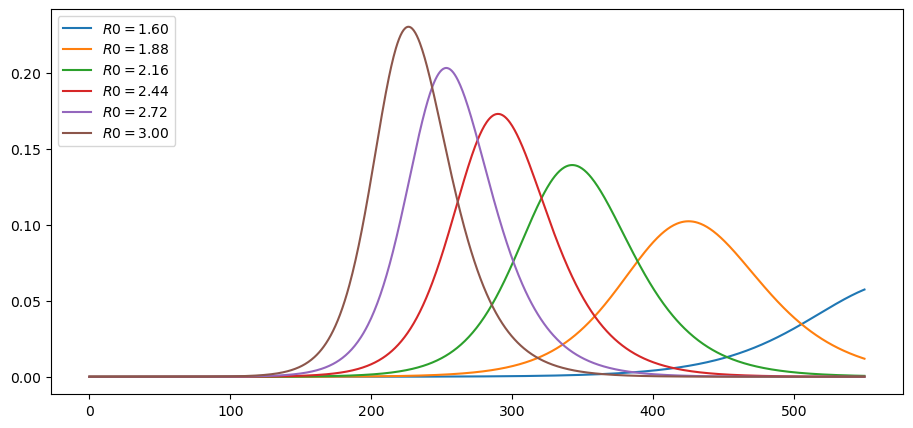

In [12]:
plot_paths(i_paths, labels)

As expected, lower effective transmission rates defer the peak of infections.

They also lead to a lower peak in current cases.

Here are cumulative cases, as a fraction of population:

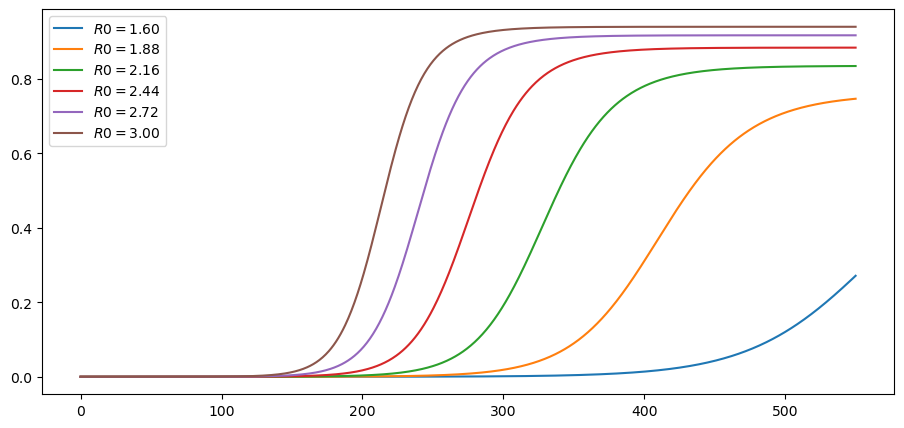

In [13]:
plot_paths(c_paths, labels)

### Experiment 2: Changing Mitigation

Let's look at a scenario where mitigation (e.g., social distancing) is
successively imposed.

Here's a specification for `R0` as a function of time.

In [14]:
def R0_mitigating(t, r0=3, η=1, r_bar=1.6):
    R0 = r0 * exp(- η * t) + (1 - exp(- η * t)) * r_bar
    return R0

The idea is that `R0` starts off at 3 and falls to 1.6.

This is due to progressive adoption of stricter mitigation measures.

The parameter `η` controls the rate, or the speed at which restrictions are
imposed.

We consider several different rates:

In [15]:
η_vals = 1/5, 1/10, 1/20, 1/50, 1/100
labels = [fr'$\eta = {η:.2f}$' for η in η_vals]

This is what the time path of `R0` looks like at these alternative rates:

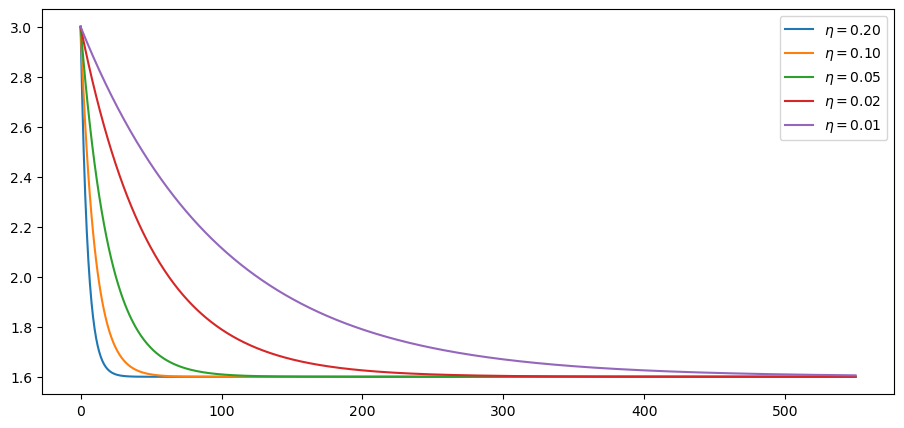

In [16]:
fig, ax = plt.subplots()

for η, label in zip(η_vals, labels):
    ax.plot(t_vec, R0_mitigating(t_vec, η=η), label=label)

ax.legend()
plt.show()

Let's calculate the time path of infected people:

In [17]:
i_paths, c_paths = [], []

for η in η_vals:
    R0 = lambda t: R0_mitigating(t, η=η)
    i_path, c_path = solve_path(R0, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

These are current cases under the different scenarios:

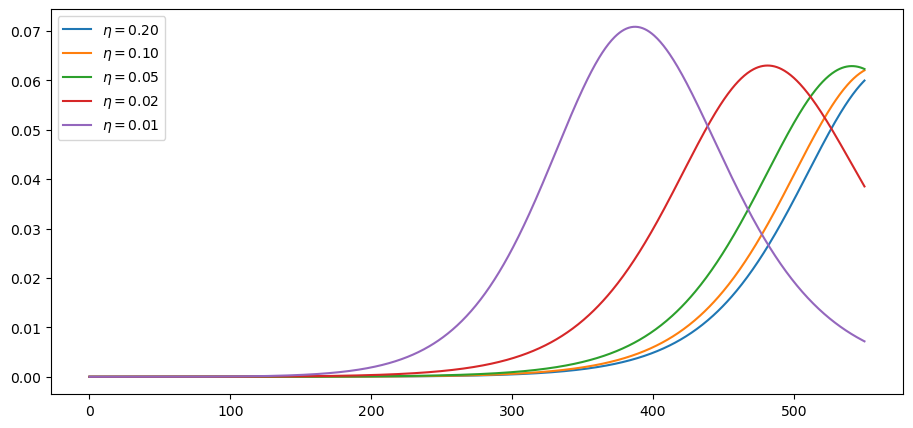

In [18]:
plot_paths(i_paths, labels)

Here are cumulative cases, as a fraction of population:

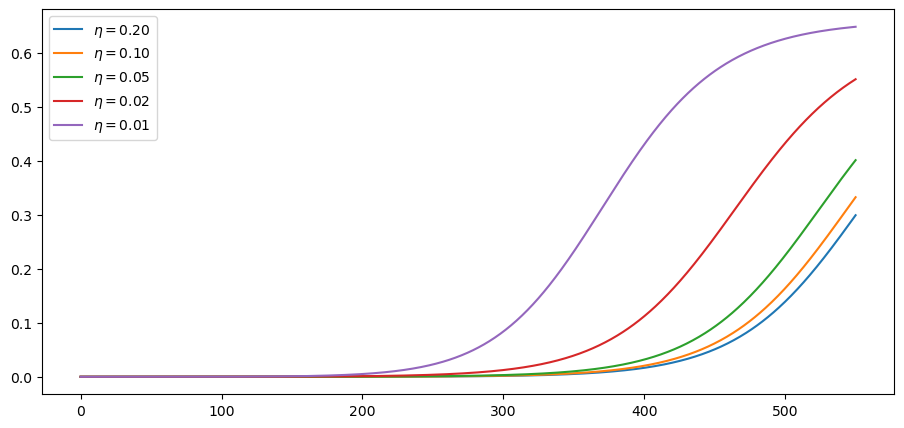

In [19]:
plot_paths(c_paths, labels)

## Ending Lockdown

The following replicates [additional results](https://drive.google.com/file/d/1uS7n-7zq5gfSgrL3S0HByExmpq4Bn3oh/view) by Andrew Atkeson on the timing of lifting lockdown.

Consider these two mitigation scenarios:

1. $R_t = 0.5$ for 30 days and then $R_t = 2$ for the remaining 17 months. This corresponds to lifting lockdown in 30 days.
1. $R_t = 0.5$ for 120 days and then $R_t = 2$ for the remaining 14 months. This corresponds to lifting lockdown in 4 months.

The parameters considered here start the model with 25,000 active infections
and 75,000 agents already exposed to the virus and thus soon to be contagious.

In [20]:
# initial conditions
i_0 = 25_000 / pop_size
e_0 = 75_000 / pop_size
s_0 = 1 - i_0 - e_0
x_0 = s_0, e_0, i_0

Let's calculate the paths:

In [21]:
R0_paths = (lambda t: 0.5 if t < 30 else 2,
            lambda t: 0.5 if t < 120 else 2)

labels = [f'scenario {i}' for i in (1, 2)]

i_paths, c_paths = [], []

for R0 in R0_paths:
    i_path, c_path = solve_path(R0, t_vec, x_init=x_0)
    i_paths.append(i_path)
    c_paths.append(c_path)

Here is the number of active infections:

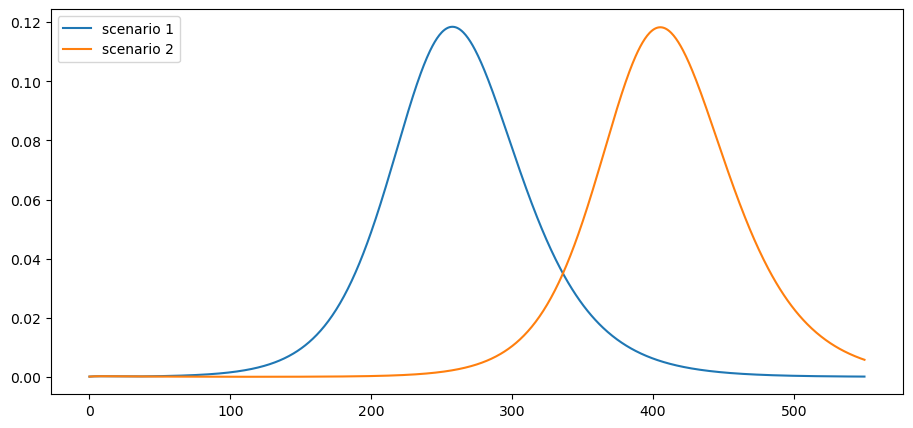

In [22]:
plot_paths(i_paths, labels)

What kind of mortality can we expect under these scenarios?

Suppose that 1% of cases result in death

In [23]:
ν = 0.01

This is the cumulative number of deaths:

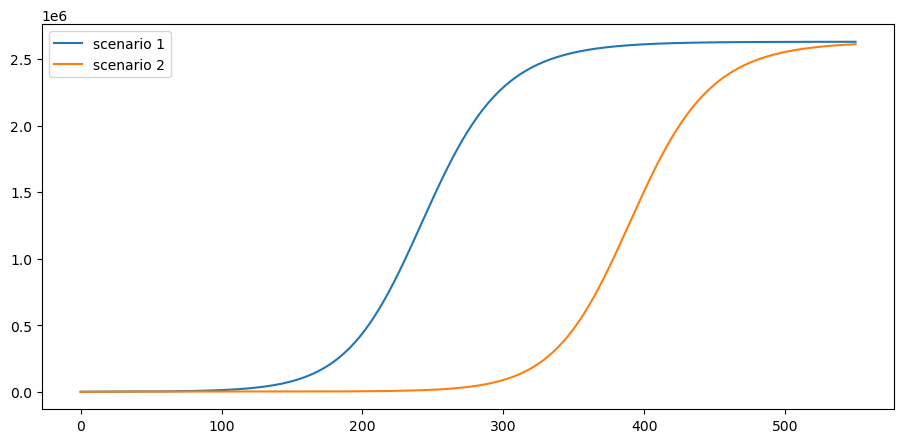

In [24]:
paths = [path * ν * pop_size for path in c_paths]
plot_paths(paths, labels)

This is the daily death rate:

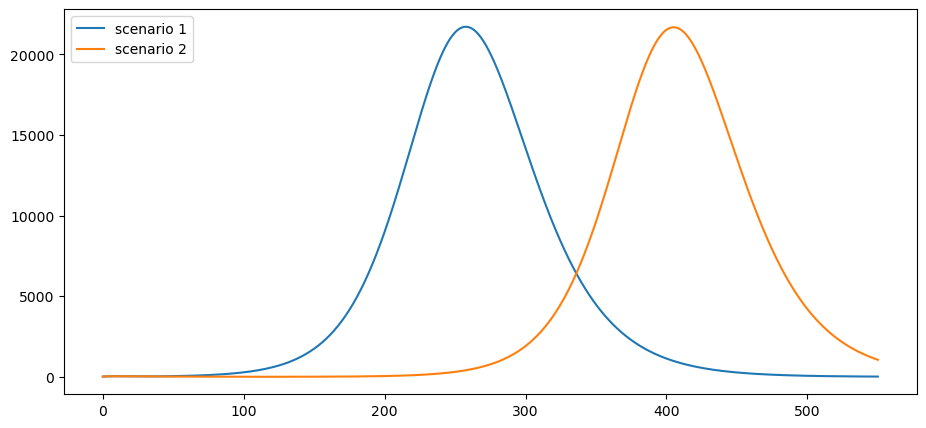

In [25]:
paths = [path * ν * γ * pop_size for path in i_paths]
plot_paths(paths, labels)

Pushing the peak of curve further into the future may reduce cumulative deaths
if a vaccine is found.